# Import Modules

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam, Adamax

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
from keras.applications import ResNet101



# To show images
from PIL import Image
print("status ok")

status ok



# Create Functions

#### Creates data frame

In [7]:
# Collect all data into one dataframe
def create_df(dataset, sample_size):
    image_paths, labels = [], []

    for dirpath, dirnames, filenames in os.walk(dataset):
        for i, filename in enumerate(filenames):
            if i >= sample_size:
                break
            
            image = os.path.join(dirpath, filename)
            image_paths.append(image)
            if dirpath[-3:] == 'all':
                labels.append('all')
            else:
                labels.append('hem')

    df = pd.DataFrame({'Image Path': image_paths, 
                       'Label': labels})
    
    return df

train_dir = "C-NMC_Leukemia/training_data"
df = create_df(train_dir, 500)

train_df, remaining_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=31, stratify=df['Label'])
valid_df, test_df = train_test_split(remaining_df, train_size=0.5, shuffle=True, random_state=31, stratify=remaining_df['Label'])

print("Number of training samples: %d" % len(train_df.index))
print("Number of test samples: %d" % len(test_df.index))  
print("Number of validation samples: %d" % len(valid_df.index))

Number of training samples: 2100
Number of test samples: 450
Number of validation samples: 450


#### Display Model Performance

In [8]:
def show_history_plot(history):

    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Improve layout and displaying the plot
    plt.tight_layout()
    plt.show()

#### Show Images

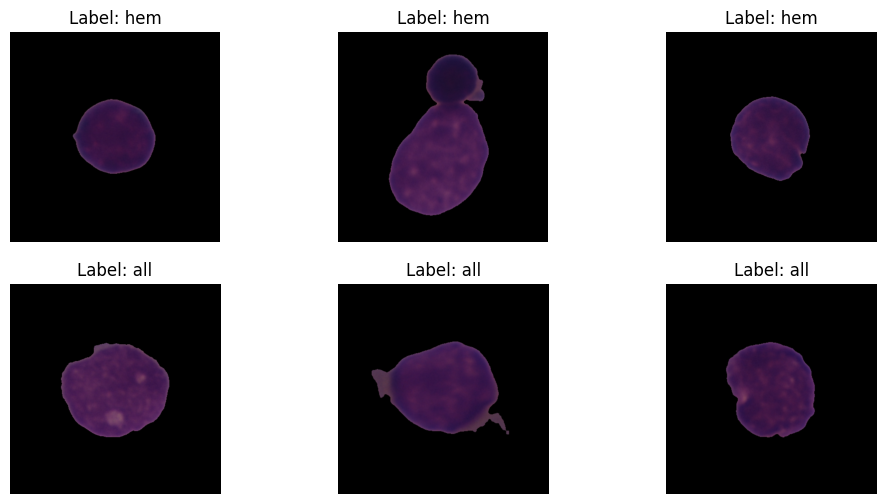

In [9]:
hem_img = train_df[train_df['Label'] == 'hem'].sample(3)
all_img = train_df[train_df['Label'] == 'all'].sample(3)
sampled_df = pd.concat([hem_img, all_img])

# Create a figure with subplots to show the images in
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, row in enumerate(sampled_df.iterrows()):
    img = mpimg.imread(row[1]['Image Path'])
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.axis('off')    
    if row[1]['Label'] == 'hem':
        ax.set_title(f"Label: hem")
    else:
        ax.set_title(f"Label: all")

plt.show()

#### Initializing Image Data Generators 

In [10]:
batch_size = 40

train_data_generator = ImageDataGenerator(horizontal_flip=True)
valid_data_generator = ImageDataGenerator()

train_gen = train_data_generator.flow_from_dataframe( train_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = valid_data_generator.flow_from_dataframe( valid_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = valid_data_generator.flow_from_dataframe( test_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

train_steps = test_gen.n // test_gen.batch_size + 1
validation_steps = valid_gen.n // valid_gen.batch_size 

Found 2100 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.
Found 450 validated image filenames belonging to 2 classes.


#### Evaluation Matrix

In [11]:
def evaluation_matrix(model):
    test_steps = len(test_df) // batch_size
    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 0)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 0)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 0)

    header = "{:<12} {:<10} {:<10}".format("", "Loss", "Accuracy") 
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f}".format("Train", train_score[0], train_score[1])  # Formats the float to five decimal places
    valid_row = "{:<12} {:<10.5f} {:<10.5f}".format("Validation", valid_score[0], valid_score[1])
    test_row = "{:<12} {:<10.5f} {:<10.5f}".format("Test", test_score[0], test_score[1])

    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    print(table)

#### Confusion Matrix

In [12]:



from keras.preprocessing.image import ImageDataGenerator



def show_conf_matrix(model):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size+1, verbose=0)

    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)  
    y_true = test_gen.classes  
    
    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

    # Plot the confusion matrix 
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)  
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7)) 
    plt.show()

# Classification Models

## ResNet-101

In [13]:
from keras.metrics import Recall, Precision
from keras.applications import ResNet101
#
from keras.optimizers import Adamax
from keras import layers, models

# Instantiate base model
img_shape = (224, 224, 3)
ResNet101_base_model = ResNet101(weights='imagenet', input_shape=img_shape, include_top=False, pooling=None)

# Freeze base model to keep pre-trained weights
ResNet101_base_model.trainable = False

# Add custom top layers for binary classification
last_layer = ResNet101_base_model.get_layer('conv5_block3_out')  # ResNet50 has a different layer structure
last_output = last_layer.output
x = layers.GlobalAveragePooling2D()(last_output)  # Change to GlobalAveragePooling2D for ResNet50
x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation='sigmoid')(x)

# Create new model
ResNet101_model = models.Model(ResNet101_base_model.input, x, name="ResNet101_model")

ResNet101_model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Recall(name='recall'), Precision(name='precision')]
)

ResNet101_model.summary()


Model: "ResNet101_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                

#### Train Model

In [14]:
epochs = 15

history_ResNet101 =ResNet101_model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)


Epoch 1/15
12/12 [==============================] - 53s 4s/step - loss: 0.8528 - accuracy: 0.5542 - recall: 0.5292 - precision: 0.5570 - val_loss: 0.6464 - val_accuracy: 0.6000 - val_recall: 0.7682 - val_precision: 0.5828
Epoch 2/15
12/12 [==============================] - 58s 5s/step - loss: 0.7784 - accuracy: 0.6292 - recall: 0.6042 - precision: 0.5598 - val_loss: 0.5855 - val_accuracy: 0.7159 - val_recall: 0.6795 - val_precision: 0.7205
Epoch 3/15
12/12 [==============================] - 62s 5s/step - loss: 0.6875 - accuracy: 0.6717 - recall: 0.6152 - precision: 0.6446 - val_loss: 0.5797 - val_accuracy: 0.7182 - val_recall: 0.7136 - val_precision: 0.7269
Epoch 4/15
12/12 [==============================] - 63s 6s/step - loss: 0.7432 - accuracy: 0.6500 - recall: 0.5826 - precision: 0.6147 - val_loss: 0.5590 - val_accuracy: 0.7386 - val_recall: 0.7477 - val_precision: 0.7000
Epoch 5/15
12/12 [==============================] - 58s 5s/step - loss: 0.6892 - accuracy: 0.6674 - recall: 0.63

#### Evaluate Model

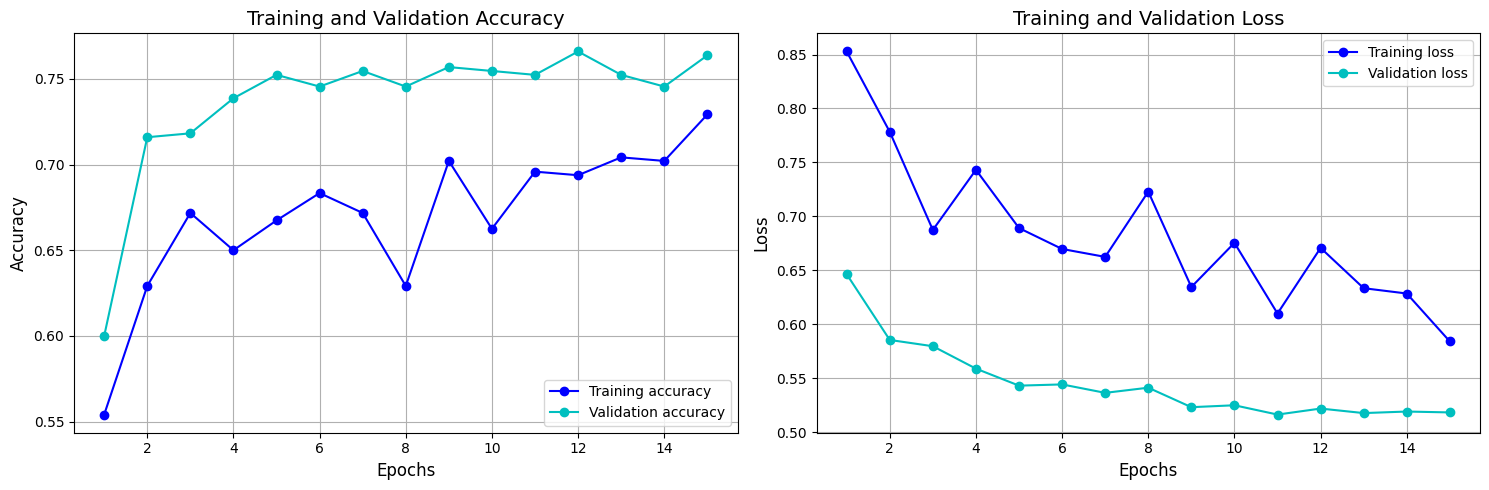

In [15]:
show_history_plot(history_ResNet101.history)


In [16]:
evaluation_matrix(ResNet101_model)

             Loss       Accuracy  
----------------------------------
Train        0.51569    0.76818   
Validation   0.51514    0.76136   
Test         0.51042    0.75455   


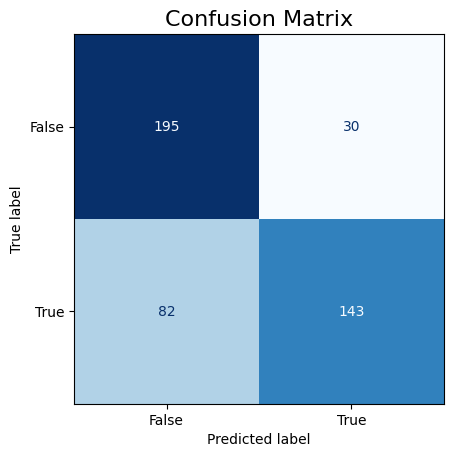

<Figure size 700x700 with 0 Axes>

In [17]:
show_conf_matrix(ResNet101_model)

In [18]:
ResNet101_model.save('Leukresnet101.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## EfficientNet

#### Train Model